# 1. Importación de librerías y carga de datos

In [4]:
# Ni escalado ni estandarizado
SCALED=False
STANDARIZED=False

In [5]:
# Importamos las librerías necesarias

import haversine as hs
import pandas as pd
import numpy as np
import pickle
import time
import os

import tensorflow as tf
tf.config.run_functions_eagerly(True)
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import LSTM, GRU, Dense, Reshape, Dropout, Bidirectional, \
  RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from haversine import inverse_haversine, Direction
from attention import Attention

if SCALED:
    from sklearn.preprocessing import MinMaxScaler
elif STANDARIZED:
    from sklearn.preprocessing import StandardScaler

from shapely import geometry
import geopy
import geopy.distance
import math

import matplotlib.pyplot as plt

from codecarbon import EmissionsTracker

In [6]:
# Hacemos el resultado reproducible
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# Declaramos el tipo de float, en este caso float64
tf.keras.backend.set_floatx('float64')

In [8]:
# Leemos y guardamos la info de segudo y vehículo
df = pd.read_csv('positions.csv')

df_data = df.sort_values(by=['vehicle_id', 'time(s)'])

columns = ['time(s)', 'vehicle_id']
df = df_data[columns]
df.head()

C:\Users\sandr\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,time(s),vehicle_id
0,1.0,0
31,2.0,0
64,3.0,0
100,4.0,0
158,5.0,0


In [9]:
# Load MinMaxScaler for target variables
if SCALED:
    MINMAXSCALER_FILE = './minmaxscaler.pkl'#os.path.join("TFM", "implementation",
                             #"data_preparation", "minmaxscaler.pkl")
    with open(MINMAXSCALER_FILE, 'rb') as f_minmaxscaler:
        minmaxscaler = pickle.load(f_minmaxscaler)
if STANDARIZED:
    TARGETS_STAND_FILE = './' #os.path.join("TFM", "implementation",
                                     #"data_preparation", "targets_stand.pkl")
    with open(TARGETS_STAND_FILE, 'rb') as f_scaler:
        standscaler_targets = pickle.load(f_scaler)

In [10]:
# Load training dataset
if SCALED:
    DATASET_TRAIN = os.path.join('./',
                               "ventanas_no_coincidentes_train_val_scaled.npz")
elif STANDARIZED:
    DATASET_TRAIN = os.path.join('./',
                               "ventanas_no_coincidentes_train_val_stand.npz")
else:
    DATASET_TRAIN = os.path.join('./',
                               "ventanas_no_coincidentes_train_val.npz")
    
npzfile = np.load(DATASET_TRAIN)
X_train = npzfile['X_train']
X_val = npzfile['X_val']
y_train = npzfile['y_train']
y_val = npzfile['y_val']
print("X_train: {}  y_train: {}\nX_val: {}  y_val: {}"
      .format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))

# Load testing dataset
if SCALED:
    DATASET_TEST = os.path.join('./',
                              "ventanas_no_coincidentes_test_scaled.npz")
elif STANDARIZED:
    DATASET_TEST = os.path.join('./',
                              "ventanas_no_coincidentes_test_stand.npz")
else:
    DATASET_TEST = os.path.join('./',
                              "ventanas_no_coincidentes_test.npz")
npzfile = np.load(DATASET_TEST)
X_test = npzfile['X_test']
y_test = npzfile['y_test']
print("X_test: {}  y_test: {}".format(X_test.shape, y_test.shape))

# Load testing vehicle ids list
VEHICLE_IDS_FILE = os.path.join('./', "vehicle_ids.pkl")
with open(VEHICLE_IDS_FILE, 'rb') as f_vehicle_ids:
    vehicle_ids = pickle.load(f_vehicle_ids)
print("Vehicle_ids: {}".format(len(vehicle_ids)))

X_train: (6005877, 20, 5)  y_train: (6005877, 5, 5)
X_val: (2573948, 20, 5)  y_val: (2573948, 5, 5)
X_test: (2402, 20, 5)  y_test: (2402, 5, 5)
Vehicle_ids: 8972


In [11]:
# Load dataset with vehicles dimensions
DATASET_DIM = os.path.join('./', "dimensions.csv")
df_dim = pd.read_csv(DATASET_DIM)
df_dim = df_dim[['vehicle_id', 'length', 'width']]
df_dim.head()

,vehicle_id,length,width
0,0,5.0,1.8
1,2,5.0,1.8
2,3,5.0,1.8
3,4,2.2,0.9
4,5,5.0,1.8


In [13]:
# Load dataset with vehicles colision
#DATASET_COL = os.path.join('./', "collisions_1k.csv")
df_col = pd.read_csv('collisions_2k.csv')
df_col = df_col[['vehicle_id', 'victim_id']].astype(int)
df_col.head()

,vehicle_id,victim_id
0,1240,5722
1,209,802
2,863,300
3,6444,3528
4,798,2787


In [14]:
# Load dataset with vehicles no-colision
#DATASET_NOCOL = os.path.join('./', "no_collisions_1k.csv")
df_nocol = pd.read_csv('no_collisions_2k.csv')
df_nocol = df_nocol[['v1', 'v2']]
df_nocol.head()

,v1,v2
0,31477,34003
1,33063,33228
2,33130,33973
3,33268,33958
4,33268,34256


In [15]:
df_col.shape

(2120, 2)

In [16]:
df_nocol.shape

(2120, 2)

# 2. Generación y entrenamiento de los modelos

In [18]:
#if SCALED:
#    MODELS_FOLDER = os.path.join("TFM", "implementation", "models", "scaled")
#elif STANDARIZED:
#    MODELS_FOLDER = os.path.join("TFM", "implementation", "models", "standarized")
#else:
#    MODELS_FOLDER = os.path.join("TFM", "implementation", "models", "real")
    
MODELS_FOLDER = './'

In [19]:
# Windows parameters
INPUT_WIDTH=20
OUTPUT_WIDTH=5
OFFSET_WIDTH=0

# Input and output columns
INPUT_COL = ['latitude(m)', 'longitude(m)', 'heading', 'speed(m/s)', 'acceleration(m/s²)']
OUTPUT_COL = ['latitude(m)', 'longitude(m)', 'heading', 'speed(m/s)', 'acceleration(m/s²)']

# Training parameters
EPOCHS= 2
BATCH_SIZE=64
PATIENCE=5
REDUCELR=0.2

def compile_and_fit(model, X_train, y_train, X_val, y_val, folder, epochs=20,
                    batch_size=32, patience=2, learning_rate=0.001, reduce_lr=0):
    tracker = EmissionsTracker(log_level="error")
    callback_list = []

    # Return best model that minimize loss function
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=patience*2, mode='min',
        restore_best_weights=True)
    callback_list.append(early_stopping)

    # Save best model that minimize loss function
    checkpoint_file = os.path.join(folder, 'model_saved.hdf5')
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_file, monitor='val_loss', mode="min",
        save_best_only=True, verbose=0)
    callback_list.append(checkpoint)
  
    if reduce_lr != 0:
        # Reduce learning rate to minimize loss function
        reduce_learningrate = ReduceLROnPlateau(
            monitor='val_loss', patience=patience, mode='min', factor=reduce_lr)
        callback_list.append(reduce_learningrate)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    tracker.start()
    start_time = time.time()
    print('X_train.shape:', X_train.shape)
    print('y_train.shape:', y_train.shape)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                      validation_data=(X_val, y_val),
                      callbacks=callback_list)
    total_time = time.time() - start_time
    emissions = tracker.stop()

    # Save fit history
    history_pickle = os.path.join(folder, 'history.pkl')
    pickle.dump(history.history, open(history_pickle, 'wb'))

    # Print and write fit statistics
    min_val_loss = min(history.history['val_loss'])
    best_model_index = history.history['val_loss'].index(min_val_loss)
    print("\nTraining Loss (MSE): {}".format(history.history['loss'][best_model_index]))
    print("Validation Loss (MSE): {}".format(history.history['val_loss'][best_model_index]))
    print("Training MAE: {}".format(history.history['mean_absolute_error'][best_model_index]))
    print("Validation MAE: {}".format(history.history['val_mean_absolute_error'][best_model_index]))
    print("Execution time (s): {}".format(total_time))
    print("Emissions (kg): {}\n".format(emissions))
    stats_file = os.path.join(folder, "stats.txt")
    with open(stats_file, 'w') as f_stats:
        f_stats.write("Training Loss (MSE): {}\n".format(history.history['loss'][best_model_index]))
        f_stats.write("Validation Loss (MSE): {}\n".format(history.history['val_loss'][best_model_index]))
        f_stats.write("Training MAE: {}\n".format(history.history['mean_absolute_error'][best_model_index]))
        f_stats.write("Validation MAE: {}\n".format(history.history['val_mean_absolute_error'][best_model_index]))
        f_stats.write("Execution time (s): {}\n".format(total_time))
        f_stats.write("Emissions (kg): {}\n".format(emissions))

    return history


def plot_history(history, start=None, end=None):
    train_loss = history['loss'][start:end]
    val_loss = history['val_loss'][start:end]
    train_mae = history['mean_absolute_error'][start:end]
    test_mae = history['val_mean_absolute_error'][start:end]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].plot(train_loss, label="Train")
    ax[0].plot(val_loss, label="Validation")
    ax[0].set_title("Training and Validation loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    ax[1].plot(train_mae, label="Train")
    ax[1].plot(test_mae, label="Validation")
    ax[1].set_title("Training and Validation MAE")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Mean Absolute Error")
    ax[1].legend()

    plt.show()


def model_predictions(model, X_test, y_test):
    def calculate_haversine(coord1, coord2):
        return hs.haversine(coord1, coord2, unit=hs.Unit.METERS)

    y_pred = model.predict(X_test)
    if SCALED:
        y_pred = minmaxscaler.inverse_transform(y_pred.reshape(-1, 2))
    elif STANDARIZED:
        y_pred = standscaler_targets.inverse_transform(y_pred.reshape(-1, 2))
    y_pred = y_pred.reshape(-1, 5)

    if SCALED:
        y_test = minmaxscaler.inverse_transform(y_test.reshape(-1, 2))
    elif STANDARIZED:
        y_test = standscaler_targets.inverse_transform(y_test.reshape(-1, 2))
    y_test = y_test.reshape(-1, 5)

    df_y_pred = pd.DataFrame(
        y_pred, columns=['latitude(pred)', 'longitude(pred)','heading(pred)', 'speed(m/s)(pred)', 'acceleration(m/s²)(pred)'])
    df_y_test = pd.DataFrame(y_test, columns=['latitude', 'longitude', 'heading', 'speed(m/s)', 'acceleration(m/s²)'])
    df_pred = pd.concat([df_y_pred, df_y_test], axis=1)

    distance = df_pred.apply(
        lambda row: calculate_haversine((row['latitude(pred)'], row['longitude(pred)']),
                                        (row['latitude'], row['longitude'])), axis=1)
    df_pred['distance(m)'] = distance

    return df_pred

In [27]:
import warnings
warnings.filterwarnings('ignore')

def bearing_calc(a_lat, a_lon, b_lat, b_lon): # a previous position b current position
    rlat1 = math.radians(a_lat)
    rlon1 = math.radians(a_lon)
    rlat2 = math.radians(b_lat)
    rlon2 = math.radians(b_lon)
    dlon = math.radians(b_lon - a_lon)
    b = math.atan2(
      math.sin(dlon)*math.cos(rlat2),
      math.cos(rlat1)*math.sin(rlat2)-math.sin(rlat1)*math.cos(rlat2)*math.cos(dlon))  # bearing calc
    bd = math.degrees(b)
    br, bn = divmod(bd + 360, 360)  # the bearing remainder and final bearing
    return bn


# To get a rotated rectangle at a bearing, you need to get the points of the the recatangle at that bearing
def get_rotated_points(coordinates, bearing, width, length):
    start = geopy.Point(coordinates)
    width = width/1000
    length = length/1000
    rectlength = geopy.distance.distance(kilometers=length)
    rectwidth = geopy.distance.distance(kilometers=width)
    halfwidth = geopy.distance.distance(kilometers=width/2)
    halflength = geopy.distance.distance(kilometers=length/2)

    pointAB = halflength.destination(point=start, bearing=bearing)
    pointA = halfwidth.destination(point=pointAB, bearing=0 - bearing)
    pointB = rectwidth.destination(point=pointA, bearing=180 - bearing)
    pointC = rectlength.destination(point=pointB, bearing=bearing - 180)
    pointD = rectwidth.destination(point=pointC, bearing=0 - bearing)

    points = []
    for point in [pointA, pointB, pointC, pointD]:
        coords = (point.latitude, point.longitude)
        points.append(coords)

    return points

def get_colision(v1_id, v2_id, X_test_v1, X_test_v2, dimensions, model):
    colision = 0

    y_pred_v1 = model.predict(X_test_v1.reshape(1, 20, 5), verbose=0)
    if SCALED:
        y_pred_v1 = minmaxscaler.inverse_transform(y_pred_v1.reshape(-1, 2))
    elif STANDARIZED:
        y_pred_v1 = standscaler_targets.inverse_transform(y_pred_v1.reshape(-1, 2))
    y_pred_v1 = y_pred_v1.reshape(-1, 5)
    v1_coord_5 = y_pred_v1[-1]
  # v1_coord_4 = y_pred_v1[-2]

    v1_length = dimensions[dimensions['vehicle_id'] == v1_id].iloc[0, 1]
    v1_width = dimensions[dimensions['vehicle_id'] == v1_id].iloc[0, 2]

  # v1_bearing = bearing_calc(v1_coord_4[0], v1_coord_4[1],
  #                           v1_coord_5[0], v1_coord_5[1])
    v1_points = get_rotated_points(tuple(v1_coord_5[:2]), v1_coord_5[-1],
                                 v1_width, v1_length)
    polygon1 = geometry.Polygon(v1_points)

    y_pred_v2 = model.predict(X_test_v2.reshape(1, 20, 5), verbose=0)
    if SCALED:
        y_pred_v2 = minmaxscaler.inverse_transform(y_pred_v2.reshape(-1, 5))
    elif STANDARIZED:
        y_pred_v2 = standscaler_targets.inverse_transform(y_pred_v2.reshape(-1, 2))
    y_pred_v2 = y_pred_v2.reshape(-1, 5)
    v2_coord_5 = y_pred_v2[-1]
  # v2_coord_4 = y_pred_v2[-2]

    v2_length = dimensions[dimensions['vehicle_id'] == v2_id].iloc[0, 1]
    v2_width = dimensions[dimensions['vehicle_id'] == v2_id].iloc[0, 2]

  # v2_bearing = bearing_calc(v2_coord_4[0], v2_coord_4[1],
  #                           v2_coord_5[0], v2_coord_5[1])
    v2_points = get_rotated_points(tuple(v2_coord_5[:2]), v2_coord_5[-1],
                                 v2_width, v2_length)
    polygon2 = geometry.Polygon(v2_points)

    if polygon1.intersection(polygon2).area > 0.0:
        colision = 1
  
    return colision

def get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
                metrics_file):
    total_colision = 0
    total_no_colision = 0

    true_positive = 0
    false_negative = 0
    false_positive = 0
    true_negative = 0

    # Vehiculos que coinciden y colisionan
    print('coinciden y colisionan:', df_col.shape[0])
    i = 0
    while (true_positive + false_negative) < 1200 and i < df_col.shape[0]:
    #for i in range(df_col.shape[0]):
        if i%100 == 0:
            print(i)
        v1_id = df_col.iloc[i, 0]
        v2_id = df_col.iloc[i, 1]

        v1_ts_set = set(df[df['vehicle_id'] == v1_id].iloc[-5:, 0])
        v2_ts_set = set(df[df['vehicle_id'] == v2_id].iloc[-5:, 0])
        intersection = sorted(list(v1_ts_set.intersection(v2_ts_set)))
        if len(intersection) >= 2:
            total_colision += 1
            #v1_index = vehicle_ids.index(v1_id)
            #v2_index = vehicle_ids.index(v2_id)
            
            # Cogemos los 20 segundos antes de la intersección
            X_v1 = df_data.loc[(df_data['vehicle_id'] == v1_id) & 
                               (df_data['time(s)'].isin(range(int(min(v1_ts_set))-20, int(min(v1_ts_set))))),
                              INPUT_COL].values.tolist()
            X_v2 = df_data.loc[(df_data['vehicle_id'] == v2_id) & 
                               (df_data['time(s)'].isin(range(int(min(v2_ts_set))-20, int(min(v2_ts_set))))),
                              INPUT_COL].values.tolist()
            #if get_colision(v1_id, v2_id, X_test[v1_index], X_test[v2_index], df_dim, model):
            if len(X_v1) == 20 and len(X_v2) == 20 and get_colision(v1_id, v2_id, np.array(X_v1), np.array(X_v2), df_dim, model):
                true_positive += 1
            else:
                false_negative += 1
        i = i+1
            

    # Vehiculos que coinciden pero no colisionan
    print('coinciden pero no colisionan:', df_nocol.shape[0])
    i = 0
    while (false_positive + true_negative) < 1200 and i < df_nocol.shape[0]:
    #for i in range(df_nocol.shape[0]):
        if i%100 == 0:
            print(i)
        v1_id = df_nocol.iloc[i, 0]
        v2_id = df_nocol.iloc[i, 1]

        v1_ts_set = set(df[df['vehicle_id'] == v1_id].iloc[-5:, 0])
        v2_ts_set = set(df[df['vehicle_id'] == v2_id].iloc[-5:, 0])
        intersection = sorted(list(v1_ts_set.intersection(v2_ts_set)))
        if len(intersection) >= 2:
            total_no_colision += 1 
            #v1_index = vehicle_ids.index(v1_id)
            #v2_index = vehicle_ids.index(v2_id)
            
            # Cogemos los 20 segundos antes de la intersección
            X_v1 = df_data.loc[(df_data['vehicle_id'] == v1_id) & 
                               (df_data['time(s)'].isin(range(int(min(v1_ts_set))-20, int(min(v1_ts_set))))),
                              INPUT_COL].values.tolist()
            X_v2 = df_data.loc[(df_data['vehicle_id'] == v2_id) & 
                               (df_data['time(s)'].isin(range(int(min(v2_ts_set))-20, int(min(v2_ts_set))))),
                              INPUT_COL].values.tolist()
            
            #if get_colision(v1_id, v2_id, X_test[v1_index], X_test[v2_index], df_dim, model):
            if len(X_v1) == 20 and len(X_v2) == 20 and get_colision(v1_id, v2_id, np.array(X_v1), np.array(X_v2), df_dim, model):
                false_positive += 1
            else:
                true_negative += 1
        i = i+1

    print('false_positive:', false_positive)
    print('true_negative:', true_negative)
    accuracy = (true_positive+true_negative)/(true_positive+false_positive+false_negative+true_negative)
    precision = true_positive/(true_positive+false_positive) if (true_positive+false_positive) != 0 else 0
    recall = true_positive/(true_positive+false_negative) if (true_positive+false_negative) != 0 else 0
    F1_score = 2*(recall*precision)/(recall+precision) if (recall+precision) != 0 else 0
    specificity = true_negative/(true_negative+false_positive) if (true_negative+false_positive) != 0 else 0

    with open(metrics_file, 'w') as f_metrics:
        f_metrics.write("Total colision: {}\n".format(total_colision))
        f_metrics.write("TP: {}\n".format(true_positive))
        f_metrics.write("FN: {}\n".format(false_negative))
        f_metrics.write("Total no colision: {}\n".format(total_no_colision))
        f_metrics.write("FP: {}\n".format(false_positive))
        f_metrics.write("TN: {}\n\n".format(true_negative))
        f_metrics.write("Accuracy: {}\n".format(accuracy))
        f_metrics.write("Precision: {}\n".format(precision))
        f_metrics.write("Recall: {}\n".format(recall))
        f_metrics.write("F1 Score: {}\n".format(F1_score))
        f_metrics.write("Specificity: {}\n".format(specificity))


    print("Total colision: {}".format(total_colision))
    print("TP: {}".format(true_positive))
    print("FN: {}".format(false_negative))
    print("Total no colision: {}".format(total_no_colision))
    print("FP: {}".format(false_positive))
    print("TN: {}".format(true_negative))
    print()
    print("Accuracy: {}".format(accuracy))
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("F1 Score: {}".format(F1_score))
    print("Specificity: {}".format(specificity))

## 2.1. Simples

In [15]:
def make_lstm_model(units, in_steps, out_steps, in_features, out_features):
    lstm_model = Sequential()

    # Shape [batch, time, in_features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    lstm_model.add(LSTM(
      units, input_shape=(in_steps, in_features)))

    # Shape => [batch, out_steps*out_features].
    lstm_model.add(Dense(out_steps*out_features))

    # Shape => [batch, out_steps, out_features].
    lstm_model.add(Reshape([out_steps, out_features]))

    lstm_model.summary()

    return lstm_model

### 2.1.1. Modelo LSTM (64 unidades)

#### 2.1.1.1. Creación y entrenamiento de la red

In [16]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v2", "LSTM_64units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS=64

# Create, compile and fit model
lstm_model = make_lstm_model(LSTM_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17920     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 reshape (Reshape)           (None, 5, 5)              0         
                                                                 
Total params: 19,545
Trainable params: 19,545
Non-trainable params: 0
_________________________________________________________________
X_train.shape: (6005877, 20, 5)
y_train.shape: (6005877, 5, 5)
Epoch 1/2
93842/93842 [==============================] - 11585s 123ms/step - loss: 223.0000 - mean_absolute_error: 2.2877 - val_loss: 85.2450 - val_mean_absolute_error: 1.3388 - lr: 0.0010
Epoch 2/2
93842/93842 [==============================] - 11486s 

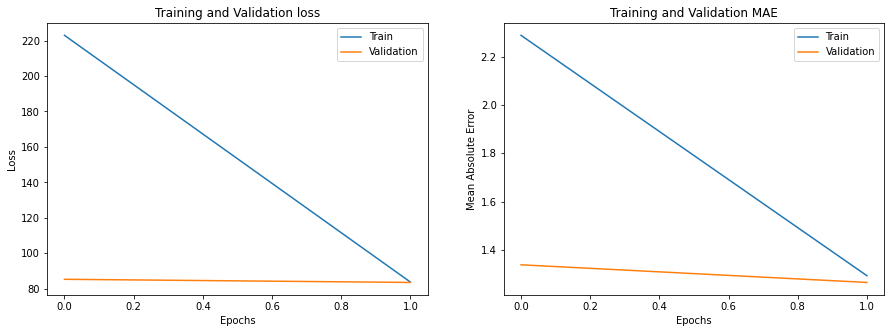

In [17]:
plot_history(history.history)

#### 2.1.1.2. Predicción de la red

In [18]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

76/76 [==============================] - 3s 45ms/step
Distance(m): [5.024327647184805, 410445.8392447531]


,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
0,41.395735,2.150550,72.747928,0.050652,-0.101418,41.394340,2.151350,72.348077,0.000000,0.000000,168.826171
1,41.395543,2.150547,73.135789,0.002476,-0.074600,41.394340,2.151350,72.348077,0.000000,0.000000,149.629580
2,41.395873,2.150561,73.314855,-0.003975,0.002001,41.394340,2.151350,72.348077,0.000000,0.000000,182.735891
3,41.395922,2.150541,73.424539,0.015512,0.011284,41.394340,2.151350,72.348077,0.000000,0.000000,188.368919
4,41.395716,2.150543,73.651042,0.089885,0.063259,41.394340,2.151350,72.348077,0.000000,0.000000,167.160229
...,...,...,...,...,...,...,...,...,...,...,...
12005,41.382686,2.150754,56.796725,8.139504,-0.314240,41.400268,2.151179,44.652289,7.775367,0.289365,1955.277853
12006,41.382233,2.150843,64.158796,7.903124,-0.323855,41.400317,2.151234,39.488036,7.149873,-0.625495,2011.148695
12007,41.383164,2.150806,69.818994,7.723773,-0.264123,41.400383,2.151277,23.947936,8.208109,1.058236,1915.118478
12008,41.383306,2.150914,75.200324,7.524982,-0.183266,41.400452,2.151264,348.255669,8.071555,-0.136553,1906.786674


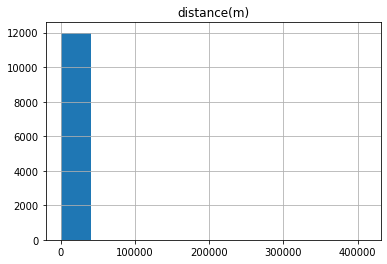

In [19]:
df_pred.hist('distance(m)')
plt.show()

In [20]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
    if i%5 == 0:
        list_1seg[i] = True
    elif i%5 == 1:
        list_2seg[i] = True
    elif i%5 == 2:
        list_3seg[i] = True
    elif i%5 == 3:
        list_4seg[i] = True
    elif i%5 == 4:
        list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [21]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [12.388765376235071, 393615.71239543526]
Segundo 2: [12.324043896769124, 410445.8392447531]
Segundo 3: [13.922858419714892, 385337.8192765213]
Segundo 4: [13.361201575994274, 382990.2319987838]
Segundo 5: [5.024327647184805, 394584.6586076501]


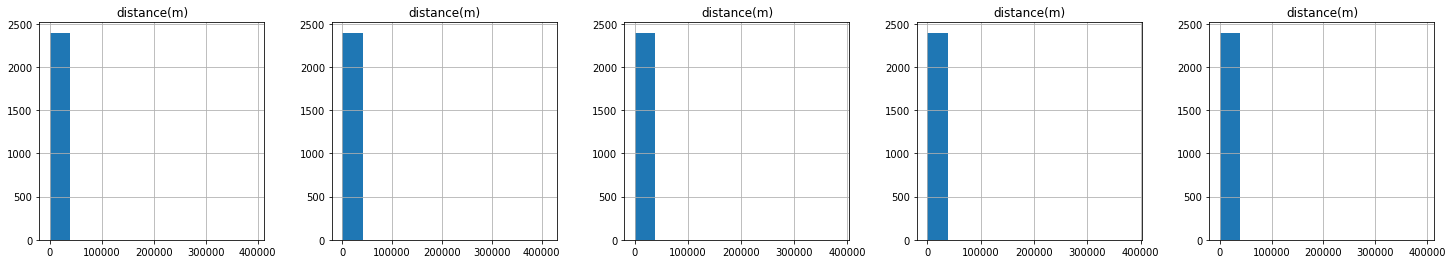

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [23]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.390356,2.147585,183.910479,5.592520,-0.149557,41.396994,2.149619,184.171392,5.743007,0.164075,1356.082680
std,0.080350,0.002184,97.011263,4.860824,0.240502,0.002307,0.003671,98.232361,5.102721,1.308594,8869.532053
min,37.856943,2.138307,7.678699,-2.755413,-1.209397,41.390906,2.139125,0.939814,0.000000,-10.000000,12.388765
25%,41.388412,2.146323,103.239793,0.473360,-0.329319,41.395245,2.147242,101.919406,0.172846,-0.104516,473.898035
50%,41.391528,2.147989,152.544303,5.333715,-0.066053,41.396960,2.149929,155.247244,4.966377,0.000000,799.763835
75%,41.396467,2.149270,258.068936,10.176223,-0.012504,41.398961,2.151950,256.275266,10.340684,0.774525,1329.813851
max,41.802320,2.152610,329.038280,17.406220,1.182884,41.401814,2.158624,357.404922,16.640354,5.988961,393615.712395


In [24]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.389894,2.147584,184.202549,5.457260,-0.199537,41.396996,2.149621,184.160835,5.890808,0.147801,1410.458983
std,0.083785,0.002227,95.330961,4.608728,0.302250,0.002308,0.003673,98.298534,4.947635,1.448525,9250.114362
min,37.705589,2.138172,7.204464,-2.630586,-1.055886,41.390873,2.139078,0.939814,0.000000,-10.000000,12.324044
25%,41.387933,2.146310,103.996739,0.529756,-0.432277,41.395234,2.147314,101.844412,0.968818,-0.154634,496.178594
50%,41.391191,2.148017,153.903175,5.391889,-0.075011,41.396960,2.149913,155.264593,5.239587,0.030756,830.203039
75%,41.396253,2.149290,259.209159,9.811368,0.006909,41.398949,2.151951,256.443895,9.990617,0.898349,1395.046328
max,41.817697,2.156935,328.004711,16.430362,0.841488,41.401864,2.158743,358.402101,16.602367,5.993102,410445.839245


In [25]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.390668,2.147589,184.439481,5.261601,-0.189082,41.396996,2.149623,184.186244,6.081826,0.191018,1324.135544
std,0.078668,0.002247,93.727116,4.329542,0.329532,0.002308,0.003675,98.566199,4.650839,1.636780,8683.086547
min,37.931397,2.138169,7.473380,-2.377413,-1.118954,41.390836,2.139009,0.373142,0.000000,-9.706740,13.922858
25%,41.388774,2.146325,105.695730,0.563127,-0.440664,41.395221,2.147382,103.263678,2.096294,-0.201319,454.533791
50%,41.391839,2.148082,154.325180,5.401499,-0.035287,41.396951,2.149961,155.606261,5.454008,0.089373,779.355302
75%,41.396694,2.149337,260.795553,9.397933,0.039391,41.398932,2.151952,262.182490,9.341440,1.054450,1295.803305
max,41.793771,2.152177,325.405856,15.288944,0.549843,41.401915,2.158883,359.323010,16.546956,5.998546,385337.819277


In [26]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.390777,2.147565,184.542034,5.056433,-0.185178,41.396997,2.149625,183.173735,6.130936,0.049110,1314.801225
std,0.078191,0.002284,91.920307,4.061450,0.318255,0.002309,0.003675,99.410339,4.357840,1.918388,8630.087178
min,37.952502,2.137977,8.998327,-2.146823,-1.104863,41.390802,2.138863,2.280386,0.000000,-10.000000,13.361202
25%,41.388900,2.146270,104.931273,0.583026,-0.431620,41.395206,2.147430,94.463904,2.726005,-0.410908,449.383188
50%,41.391933,2.148079,155.202332,5.338431,-0.032694,41.396931,2.150051,160.120137,5.748746,0.085084,771.928013
75%,41.396817,2.149333,260.513394,8.936442,0.044070,41.398903,2.151970,268.070273,8.739849,1.113957,1283.312510
max,41.791451,2.153111,324.479243,14.157296,0.515206,41.401967,2.158981,359.017348,16.626126,5.996870,382990.231999


In [27]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.390313,2.147560,184.367096,4.892075,-0.141605,41.396997,2.149628,176.707990,6.117309,0.105156,1360.200933
std,0.080553,0.002308,89.890468,3.827224,0.281080,0.002309,0.003675,100.425471,4.092248,1.903228,8891.803642
min,37.848232,2.137914,8.423599,-1.846712,-0.961934,41.390767,2.138725,0.598478,0.000000,-10.000000,5.024328
25%,41.388372,2.146244,106.331322,0.629471,-0.354256,41.395191,2.147420,74.637179,3.188963,-0.242367,474.255853
50%,41.391495,2.148117,155.890718,5.290999,-0.022599,41.396900,2.150056,147.086299,6.220898,0.103251,803.465676
75%,41.396490,2.149359,260.426287,8.552659,0.060620,41.398873,2.151995,261.391452,8.441894,1.059701,1335.527239
max,41.802466,2.152344,322.935410,13.220924,0.412330,41.402028,2.159084,359.352131,16.601876,5.982253,394584.658608


#### 2.1.1.3. Métricas del modelo

In [23]:
# Load fitted model 
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v2", "LSTM_64units")
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE, compile=False) #https://stackoverflow.com/questions/48373845/loading-model-with-custom-loss-keras

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim, METRICS_FILE)

coinciden y colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
coinciden pero no colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
false_positive: 23
true_negative: 1818
Total colision: 2120
TP: 8
FN: 2112
Total no colision: 1841
FP: 23
TN: 1818

Accuracy: 0.460994698308508
Precision: 0.25806451612903225
Recall: 0.0037735849056603774
F1 Score: 0.007438400743840075
Specificity: 0.9875067897881586


In [34]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v2", "LSTM_32units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS=32

# Create, compile and fit model
lstm_model = make_lstm_model(LSTM_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4864      
                                                                 
 dense_1 (Dense)             (None, 25)                825       
                                                                 
 reshape_1 (Reshape)         (None, 5, 5)              0         
                                                                 
Total params: 5,689
Trainable params: 5,689
Non-trainable params: 0
_________________________________________________________________
X_train.shape: (6005877, 20, 5)
y_train.shape: (6005877, 5, 5)
Epoch 1/2
93842/93842 [==============================] - 11784s 126ms/step - loss: 346.3444 - mean_absolute_error: 3.0584 - val_loss: 88.0578 - val_mean_absolute_error: 1.3150 - lr: 0.0010
Epoch 2/2
93842/93842 [==============================] - 11434s 

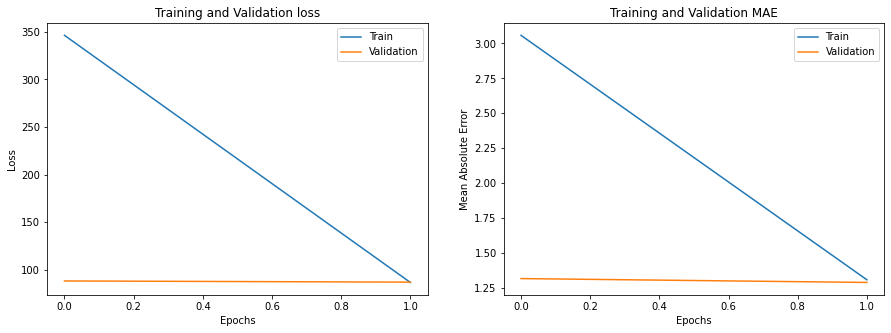

In [35]:
plot_history(history.history)

In [36]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

76/76 [==============================] - 2s 30ms/step
Distance(m): [1.2929631218137774, 909370.5573107185]


,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
0,41.393391,2.151272,71.831326,0.151650,-0.049411,41.394340,2.151350,72.348077,0.000000,0.000000,105.743597
1,41.393612,2.151273,71.892563,0.156989,0.003551,41.394340,2.151350,72.348077,0.000000,0.000000,81.174793
2,41.393616,2.151279,72.019274,0.187120,0.025269,41.394340,2.151350,72.348077,0.000000,0.000000,80.729712
3,41.393657,2.151295,72.208833,0.248546,0.027662,41.394340,2.151350,72.348077,0.000000,0.000000,76.140735
4,41.393710,2.151301,72.390190,0.342151,0.077100,41.394340,2.151350,72.348077,0.000000,0.000000,70.211627
...,...,...,...,...,...,...,...,...,...,...,...
12005,41.395944,2.148276,62.883322,5.099865,-0.101600,41.400268,2.151179,44.652289,7.775367,0.289365,538.320160
12006,41.395258,2.148337,69.027004,5.122598,0.014709,41.400317,2.151234,39.488036,7.149873,-0.625495,612.270412
12007,41.395287,2.148359,74.268931,5.197738,0.074571,41.400383,2.151277,23.947936,8.208109,1.058236,616.737884
12008,41.395209,2.148416,79.446875,5.362772,0.115782,41.400452,2.151264,348.255669,8.071555,-0.136553,629.528861


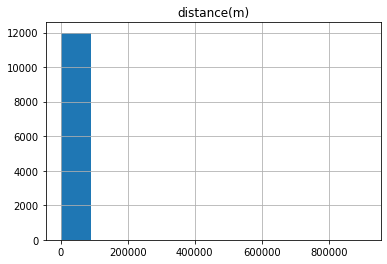

In [37]:
df_pred.hist('distance(m)')
plt.show()

In [38]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
    if i%5 == 0:
        list_1seg[i] = True
    elif i%5 == 1:
        list_2seg[i] = True
    elif i%5 == 2:
        list_3seg[i] = True
    elif i%5 == 3:
        list_4seg[i] = True
    elif i%5 == 4:
        list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [39]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [4.963413912284655, 909370.5573107185]
Segundo 2: [1.332348967241643, 856094.6667832797]
Segundo 3: [2.645963772368199, 855708.6725415634]
Segundo 4: [1.2929631218137774, 846766.1781152483]
Segundo 5: [5.411079610276816, 830648.7852730274]


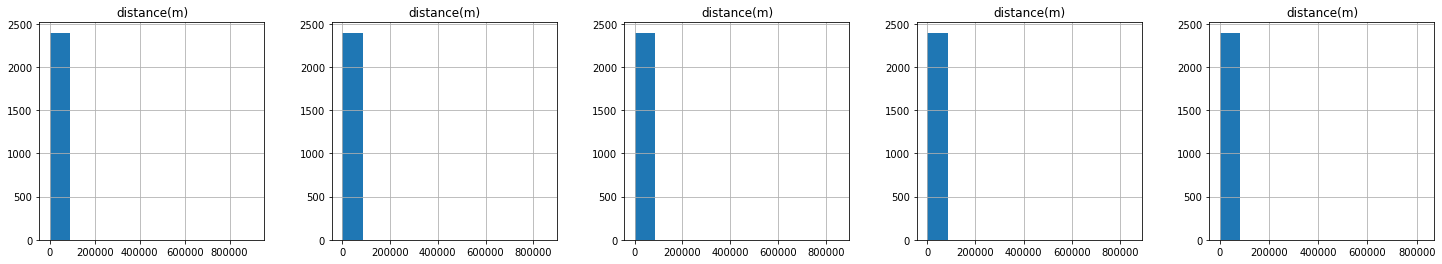

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [41]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.388297,2.150809,182.950708,5.179340,-0.084267,41.396994,2.149619,184.171392,5.743007,0.164075,2182.831502
std,0.241977,0.001808,96.554450,4.403373,0.215311,0.002307,0.003671,98.232361,5.102721,1.308594,26844.530301
min,33.218672,2.129333,5.656498,-3.621479,-0.879341,41.390906,2.139125,0.939814,0.000000,-10.000000,4.963414
25%,41.391004,2.149514,96.464808,0.444555,-0.238374,41.395245,2.147242,101.919406,0.172846,-0.104516,399.556615
50%,41.396008,2.150975,152.406872,5.404735,-0.031030,41.396960,2.149929,155.247244,4.966377,0.000000,813.678126
75%,41.403008,2.152256,256.440241,9.016244,0.059817,41.398961,2.151950,256.275266,10.340684,0.774525,1331.369372
max,42.021917,2.155335,327.289046,12.804696,0.462567,41.401814,2.158624,357.404922,16.640354,5.988961,909370.557311


In [42]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.388798,2.150823,183.523477,5.042962,-0.127797,41.396996,2.149621,184.160835,5.890808,0.147801,2073.630606
std,0.227891,0.001777,94.873453,4.200133,0.240857,0.002308,0.003673,98.298534,4.947635,1.448525,25281.056872
min,33.697792,2.130485,5.703299,-3.404685,-0.755448,41.390873,2.139078,0.939814,0.000000,-10.000000,1.332349
25%,41.391241,2.149522,99.993343,0.491880,-0.336662,41.395234,2.147314,101.844412,0.968818,-0.154634,392.204894
50%,41.395946,2.150959,153.534990,5.345029,-0.038487,41.396960,2.149913,155.264593,5.239587,0.030756,796.182086
75%,41.402949,2.152246,257.076244,8.718030,0.075111,41.398949,2.151951,256.443895,9.990617,0.898349,1284.730648
max,41.991051,2.155365,327.137889,12.393707,0.390648,41.401864,2.158743,358.402101,16.602367,5.993102,856094.666783


In [43]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.388786,2.150821,184.095736,4.845448,-0.186525,41.396996,2.149623,184.186244,6.081826,0.191018,2072.965252
std,0.227787,0.001810,93.391220,3.966813,0.276361,0.002308,0.003675,98.566199,4.650839,1.636780,25269.685528
min,33.701273,2.125672,6.265689,-3.211852,-0.782367,41.390836,2.139009,0.373142,0.000000,-9.706740,2.645964
25%,41.391230,2.149566,103.969210,0.443953,-0.390212,41.395221,2.147382,103.263678,2.096294,-0.201319,391.852084
50%,41.395917,2.150918,154.647759,5.282937,-0.053589,41.396951,2.149961,155.606261,5.454008,0.089373,796.692279
75%,41.402970,2.152218,257.375299,8.363735,0.028370,41.398932,2.151952,262.182490,9.341440,1.054450,1285.794752
max,41.990792,2.155382,326.688413,11.629797,0.472118,41.401915,2.158883,359.323010,16.546956,5.998546,855708.672542


In [44]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.388894,2.150837,184.485388,4.659665,-0.194432,41.396997,2.149625,183.173735,6.130936,0.049110,2053.958114
std,0.225424,0.001791,91.720525,3.743181,0.282205,0.002309,0.003675,99.410339,4.357840,1.918388,25007.328489
min,33.781695,2.125919,7.663965,-3.010305,-0.825330,41.390802,2.138863,2.280386,0.000000,-10.000000,1.292963
25%,41.391323,2.149608,105.921475,0.403470,-0.403459,41.395206,2.147430,94.463904,2.726005,-0.410908,392.445006
50%,41.395948,2.150898,154.823439,5.163559,-0.082918,41.396931,2.150051,160.120137,5.748746,0.085084,792.377807
75%,41.402998,2.152204,257.664919,8.019036,0.018335,41.398903,2.151970,268.070273,8.739849,1.113957,1279.557966
max,41.985793,2.155414,325.532863,11.136986,0.547572,41.401967,2.158981,359.017348,16.626126,5.996870,846766.178115


In [45]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.389017,2.150883,184.606374,4.497703,-0.152842,41.396997,2.149628,176.707990,6.117309,0.105156,2021.266766
std,0.221160,0.001693,89.955072,3.542476,0.253368,0.002309,0.003675,100.425471,4.092248,1.903228,24534.223461
min,33.926629,2.134768,7.855421,-2.787820,-0.797338,41.390767,2.138725,0.598478,0.000000,-10.000000,5.411080
25%,41.391338,2.149668,106.671763,0.406794,-0.338068,41.395191,2.147420,74.637179,3.188963,-0.242367,391.312214
50%,41.395883,2.150915,154.725957,5.070555,-0.078386,41.396900,2.150056,147.086299,6.220898,0.103251,789.041554
75%,41.402922,2.152223,257.797567,7.743063,0.040250,41.398873,2.151995,261.391452,8.441894,1.059701,1269.243384
max,41.976350,2.155465,323.746563,10.752371,0.557788,41.402028,2.159084,359.352131,16.601876,5.982253,830648.785273


In [ ]:
# Load fitted model 
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v2", "LSTM_32units")
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE, compile=False) #https://stackoverflow.com/questions/48373845/loading-model-with-custom-loss-keras

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim, METRICS_FILE)

coinciden y colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
coinciden pero no colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000


In [46]:
def make_gru_model(units, in_steps, out_steps, in_features, out_features):
    gru_model = Sequential()

    # Shape [batch, time, in_features] => [batch, gru_units].
    gru_model.add(GRU(units, input_shape=(in_steps, in_features)))

    # Shape => [batch, out_steps*out_features].
    gru_model.add(Dense(out_steps*out_features))

    # Shape => [batch, out_steps, out_features].
    gru_model.add(Reshape([out_steps, out_features]))

    gru_model.summary()

    return gru_model

In [47]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v2", "GRU_32units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
GRU_UNITS=32

# Create, compile and fit model
gru_model = make_gru_model(GRU_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(gru_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3744      
                                                                 
 dense_2 (Dense)             (None, 25)                825       
                                                                 
 reshape_2 (Reshape)         (None, 5, 5)              0         
                                                                 
Total params: 4,569
Trainable params: 4,569
Non-trainable params: 0
_________________________________________________________________
X_train.shape: (6005877, 20, 5)
y_train.shape: (6005877, 5, 5)
Epoch 1/2
93842/93842 [==============================] - 11498s 123ms/step - loss: 348.1943 - mean_absolute_error: 3.1047 - val_loss: 93.2457 - val_mean_absolute_error: 1.6917 - lr: 0.0010
Epoch 2/2
93842/93842 [==============================] - 10944s 

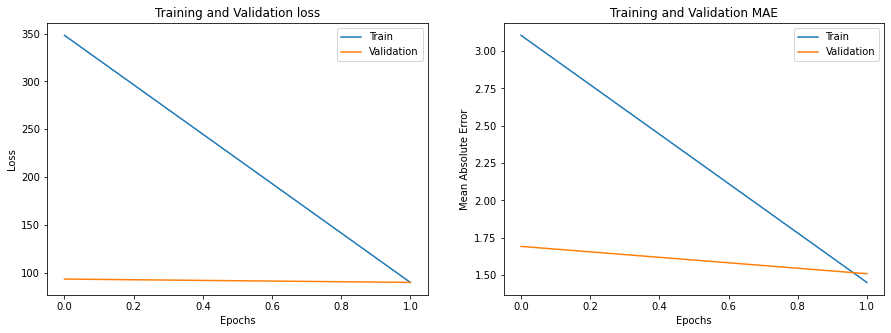

In [48]:
plot_history(history.history)

In [49]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

76/76 [==============================] - 2s 28ms/step
Distance(m): [1.2929631218137774, 909370.5573107185]


,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
0,41.393391,2.151272,71.831326,0.151650,-0.049411,41.394340,2.151350,72.348077,0.000000,0.000000,105.743597
1,41.393612,2.151273,71.892563,0.156989,0.003551,41.394340,2.151350,72.348077,0.000000,0.000000,81.174793
2,41.393616,2.151279,72.019274,0.187120,0.025269,41.394340,2.151350,72.348077,0.000000,0.000000,80.729712
3,41.393657,2.151295,72.208833,0.248546,0.027662,41.394340,2.151350,72.348077,0.000000,0.000000,76.140735
4,41.393710,2.151301,72.390190,0.342151,0.077100,41.394340,2.151350,72.348077,0.000000,0.000000,70.211627
...,...,...,...,...,...,...,...,...,...,...,...
12005,41.395944,2.148276,62.883322,5.099865,-0.101600,41.400268,2.151179,44.652289,7.775367,0.289365,538.320160
12006,41.395258,2.148337,69.027004,5.122598,0.014709,41.400317,2.151234,39.488036,7.149873,-0.625495,612.270412
12007,41.395287,2.148359,74.268931,5.197738,0.074571,41.400383,2.151277,23.947936,8.208109,1.058236,616.737884
12008,41.395209,2.148416,79.446875,5.362772,0.115782,41.400452,2.151264,348.255669,8.071555,-0.136553,629.528861


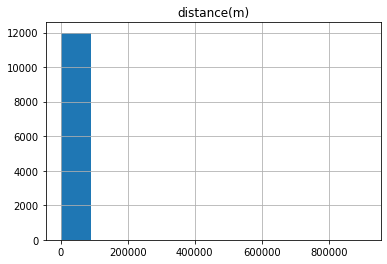

In [50]:
df_pred.hist('distance(m)')
plt.show()

In [51]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
    if i%5 == 0:
        list_1seg[i] = True
    elif i%5 == 1:
        list_2seg[i] = True
    elif i%5 == 2:
        list_3seg[i] = True
    elif i%5 == 3:
        list_4seg[i] = True
    elif i%5 == 4:
        list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [52]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [4.963413912284655, 909370.5573107185]
Segundo 2: [1.332348967241643, 856094.6667832797]
Segundo 3: [2.645963772368199, 855708.6725415634]
Segundo 4: [1.2929631218137774, 846766.1781152483]
Segundo 5: [5.411079610276816, 830648.7852730274]


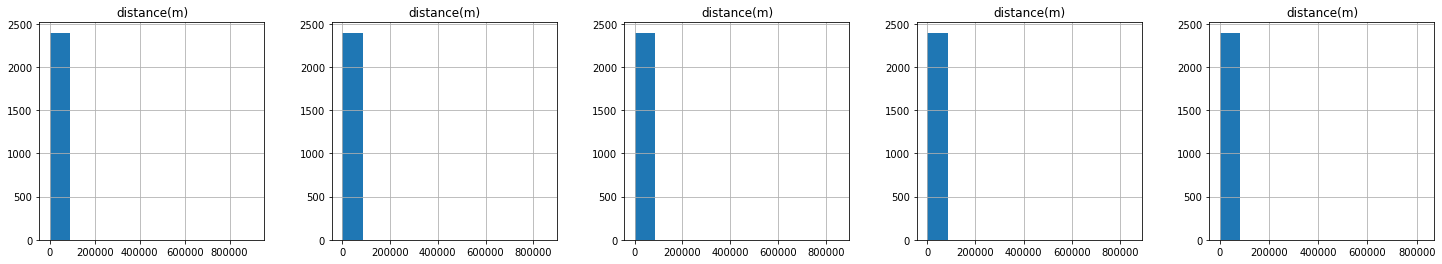

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [54]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.388297,2.150809,182.950708,5.179340,-0.084267,41.396994,2.149619,184.171392,5.743007,0.164075,2182.831502
std,0.241977,0.001808,96.554450,4.403373,0.215311,0.002307,0.003671,98.232361,5.102721,1.308594,26844.530301
min,33.218672,2.129333,5.656498,-3.621479,-0.879341,41.390906,2.139125,0.939814,0.000000,-10.000000,4.963414
25%,41.391004,2.149514,96.464808,0.444555,-0.238374,41.395245,2.147242,101.919406,0.172846,-0.104516,399.556615
50%,41.396008,2.150975,152.406872,5.404735,-0.031030,41.396960,2.149929,155.247244,4.966377,0.000000,813.678126
75%,41.403008,2.152256,256.440241,9.016244,0.059817,41.398961,2.151950,256.275266,10.340684,0.774525,1331.369372
max,42.021917,2.155335,327.289046,12.804696,0.462567,41.401814,2.158624,357.404922,16.640354,5.988961,909370.557311


In [55]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.388798,2.150823,183.523477,5.042962,-0.127797,41.396996,2.149621,184.160835,5.890808,0.147801,2073.630606
std,0.227891,0.001777,94.873453,4.200133,0.240857,0.002308,0.003673,98.298534,4.947635,1.448525,25281.056872
min,33.697792,2.130485,5.703299,-3.404685,-0.755448,41.390873,2.139078,0.939814,0.000000,-10.000000,1.332349
25%,41.391241,2.149522,99.993343,0.491880,-0.336662,41.395234,2.147314,101.844412,0.968818,-0.154634,392.204894
50%,41.395946,2.150959,153.534990,5.345029,-0.038487,41.396960,2.149913,155.264593,5.239587,0.030756,796.182086
75%,41.402949,2.152246,257.076244,8.718030,0.075111,41.398949,2.151951,256.443895,9.990617,0.898349,1284.730648
max,41.991051,2.155365,327.137889,12.393707,0.390648,41.401864,2.158743,358.402101,16.602367,5.993102,856094.666783


In [56]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.388786,2.150821,184.095736,4.845448,-0.186525,41.396996,2.149623,184.186244,6.081826,0.191018,2072.965252
std,0.227787,0.001810,93.391220,3.966813,0.276361,0.002308,0.003675,98.566199,4.650839,1.636780,25269.685528
min,33.701273,2.125672,6.265689,-3.211852,-0.782367,41.390836,2.139009,0.373142,0.000000,-9.706740,2.645964
25%,41.391230,2.149566,103.969210,0.443953,-0.390212,41.395221,2.147382,103.263678,2.096294,-0.201319,391.852084
50%,41.395917,2.150918,154.647759,5.282937,-0.053589,41.396951,2.149961,155.606261,5.454008,0.089373,796.692279
75%,41.402970,2.152218,257.375299,8.363735,0.028370,41.398932,2.151952,262.182490,9.341440,1.054450,1285.794752
max,41.990792,2.155382,326.688413,11.629797,0.472118,41.401915,2.158883,359.323010,16.546956,5.998546,855708.672542


In [57]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.388894,2.150837,184.485388,4.659665,-0.194432,41.396997,2.149625,183.173735,6.130936,0.049110,2053.958114
std,0.225424,0.001791,91.720525,3.743181,0.282205,0.002309,0.003675,99.410339,4.357840,1.918388,25007.328489
min,33.781695,2.125919,7.663965,-3.010305,-0.825330,41.390802,2.138863,2.280386,0.000000,-10.000000,1.292963
25%,41.391323,2.149608,105.921475,0.403470,-0.403459,41.395206,2.147430,94.463904,2.726005,-0.410908,392.445006
50%,41.395948,2.150898,154.823439,5.163559,-0.082918,41.396931,2.150051,160.120137,5.748746,0.085084,792.377807
75%,41.402998,2.152204,257.664919,8.019036,0.018335,41.398903,2.151970,268.070273,8.739849,1.113957,1279.557966
max,41.985793,2.155414,325.532863,11.136986,0.547572,41.401967,2.158981,359.017348,16.626126,5.996870,846766.178115


In [58]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.389017,2.150883,184.606374,4.497703,-0.152842,41.396997,2.149628,176.707990,6.117309,0.105156,2021.266766
std,0.221160,0.001693,89.955072,3.542476,0.253368,0.002309,0.003675,100.425471,4.092248,1.903228,24534.223461
min,33.926629,2.134768,7.855421,-2.787820,-0.797338,41.390767,2.138725,0.598478,0.000000,-10.000000,5.411080
25%,41.391338,2.149668,106.671763,0.406794,-0.338068,41.395191,2.147420,74.637179,3.188963,-0.242367,391.312214
50%,41.395883,2.150915,154.725957,5.070555,-0.078386,41.396900,2.150056,147.086299,6.220898,0.103251,789.041554
75%,41.402922,2.152223,257.797567,7.743063,0.040250,41.398873,2.151995,261.391452,8.441894,1.059701,1269.243384
max,41.976350,2.155465,323.746563,10.752371,0.557788,41.402028,2.159084,359.352131,16.601876,5.982253,830648.785273


In [ ]:
# Load fitted model 
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v2", "GRU_32units")
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE, compile=False) #https://stackoverflow.com/questions/48373845/loading-model-with-custom-loss-keras

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim, METRICS_FILE)

In [59]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v2", "GRU_64units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
GRU_UNITS=64

# Create, compile and fit model
gru_model = make_gru_model(GRU_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(gru_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                13632     
                                                                 
 dense_3 (Dense)             (None, 25)                1625      
                                                                 
 reshape_3 (Reshape)         (None, 5, 5)              0         
                                                                 
Total params: 15,257
Trainable params: 15,257
Non-trainable params: 0
_________________________________________________________________
X_train.shape: (6005877, 20, 5)
y_train.shape: (6005877, 5, 5)
Epoch 1/2
93842/93842 [==============================] - 12518s 133ms/step - loss: 222.9510 - mean_absolute_error: 2.3263 - val_loss: 87.3469 - val_mean_absolute_error: 1.3136 - lr: 0.0010
Epoch 2/2
93842/93842 [==============================] - 13400

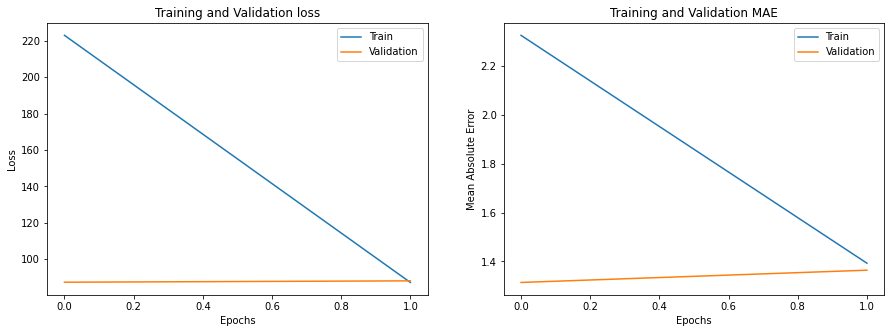

In [60]:
plot_history(history.history)

In [61]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

76/76 [==============================] - 2s 32ms/step
Distance(m): [1.2929631218137774, 909370.5573107185]


,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
0,41.393391,2.151272,71.831326,0.151650,-0.049411,41.394340,2.151350,72.348077,0.000000,0.000000,105.743597
1,41.393612,2.151273,71.892563,0.156989,0.003551,41.394340,2.151350,72.348077,0.000000,0.000000,81.174793
2,41.393616,2.151279,72.019274,0.187120,0.025269,41.394340,2.151350,72.348077,0.000000,0.000000,80.729712
3,41.393657,2.151295,72.208833,0.248546,0.027662,41.394340,2.151350,72.348077,0.000000,0.000000,76.140735
4,41.393710,2.151301,72.390190,0.342151,0.077100,41.394340,2.151350,72.348077,0.000000,0.000000,70.211627
...,...,...,...,...,...,...,...,...,...,...,...
12005,41.395944,2.148276,62.883322,5.099865,-0.101600,41.400268,2.151179,44.652289,7.775367,0.289365,538.320160
12006,41.395258,2.148337,69.027004,5.122598,0.014709,41.400317,2.151234,39.488036,7.149873,-0.625495,612.270412
12007,41.395287,2.148359,74.268931,5.197738,0.074571,41.400383,2.151277,23.947936,8.208109,1.058236,616.737884
12008,41.395209,2.148416,79.446875,5.362772,0.115782,41.400452,2.151264,348.255669,8.071555,-0.136553,629.528861


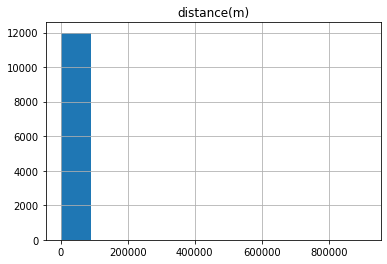

In [62]:
df_pred.hist('distance(m)')
plt.show()

In [63]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
    if i%5 == 0:
        list_1seg[i] = True
    elif i%5 == 1:
        list_2seg[i] = True
    elif i%5 == 2:
        list_3seg[i] = True
    elif i%5 == 3:
        list_4seg[i] = True
    elif i%5 == 4:
        list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [64]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [4.963413912284655, 909370.5573107185]
Segundo 2: [1.332348967241643, 856094.6667832797]
Segundo 3: [2.645963772368199, 855708.6725415634]
Segundo 4: [1.2929631218137774, 846766.1781152483]
Segundo 5: [5.411079610276816, 830648.7852730274]


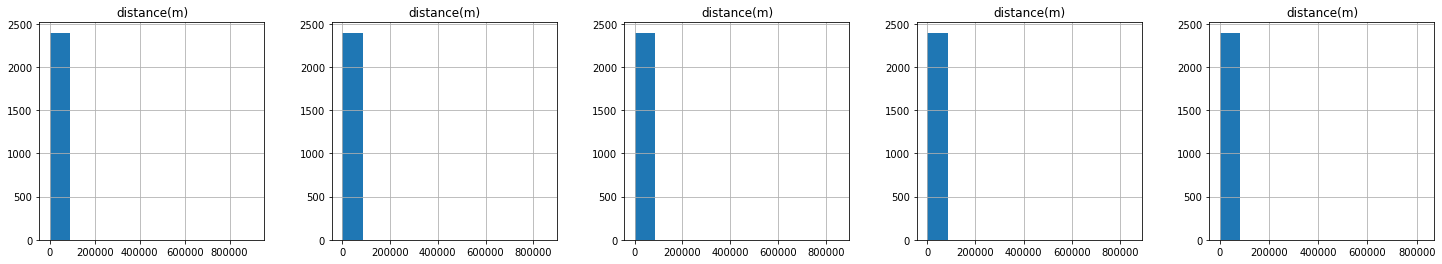

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [66]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.388297,2.150809,182.950708,5.179340,-0.084267,41.396994,2.149619,184.171392,5.743007,0.164075,2182.831502
std,0.241977,0.001808,96.554450,4.403373,0.215311,0.002307,0.003671,98.232361,5.102721,1.308594,26844.530301
min,33.218672,2.129333,5.656498,-3.621479,-0.879341,41.390906,2.139125,0.939814,0.000000,-10.000000,4.963414
25%,41.391004,2.149514,96.464808,0.444555,-0.238374,41.395245,2.147242,101.919406,0.172846,-0.104516,399.556615
50%,41.396008,2.150975,152.406872,5.404735,-0.031030,41.396960,2.149929,155.247244,4.966377,0.000000,813.678126
75%,41.403008,2.152256,256.440241,9.016244,0.059817,41.398961,2.151950,256.275266,10.340684,0.774525,1331.369372
max,42.021917,2.155335,327.289046,12.804696,0.462567,41.401814,2.158624,357.404922,16.640354,5.988961,909370.557311


In [67]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.388798,2.150823,183.523477,5.042962,-0.127797,41.396996,2.149621,184.160835,5.890808,0.147801,2073.630606
std,0.227891,0.001777,94.873453,4.200133,0.240857,0.002308,0.003673,98.298534,4.947635,1.448525,25281.056872
min,33.697792,2.130485,5.703299,-3.404685,-0.755448,41.390873,2.139078,0.939814,0.000000,-10.000000,1.332349
25%,41.391241,2.149522,99.993343,0.491880,-0.336662,41.395234,2.147314,101.844412,0.968818,-0.154634,392.204894
50%,41.395946,2.150959,153.534990,5.345029,-0.038487,41.396960,2.149913,155.264593,5.239587,0.030756,796.182086
75%,41.402949,2.152246,257.076244,8.718030,0.075111,41.398949,2.151951,256.443895,9.990617,0.898349,1284.730648
max,41.991051,2.155365,327.137889,12.393707,0.390648,41.401864,2.158743,358.402101,16.602367,5.993102,856094.666783


In [68]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.388786,2.150821,184.095736,4.845448,-0.186525,41.396996,2.149623,184.186244,6.081826,0.191018,2072.965252
std,0.227787,0.001810,93.391220,3.966813,0.276361,0.002308,0.003675,98.566199,4.650839,1.636780,25269.685528
min,33.701273,2.125672,6.265689,-3.211852,-0.782367,41.390836,2.139009,0.373142,0.000000,-9.706740,2.645964
25%,41.391230,2.149566,103.969210,0.443953,-0.390212,41.395221,2.147382,103.263678,2.096294,-0.201319,391.852084
50%,41.395917,2.150918,154.647759,5.282937,-0.053589,41.396951,2.149961,155.606261,5.454008,0.089373,796.692279
75%,41.402970,2.152218,257.375299,8.363735,0.028370,41.398932,2.151952,262.182490,9.341440,1.054450,1285.794752
max,41.990792,2.155382,326.688413,11.629797,0.472118,41.401915,2.158883,359.323010,16.546956,5.998546,855708.672542


In [69]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.388894,2.150837,184.485388,4.659665,-0.194432,41.396997,2.149625,183.173735,6.130936,0.049110,2053.958114
std,0.225424,0.001791,91.720525,3.743181,0.282205,0.002309,0.003675,99.410339,4.357840,1.918388,25007.328489
min,33.781695,2.125919,7.663965,-3.010305,-0.825330,41.390802,2.138863,2.280386,0.000000,-10.000000,1.292963
25%,41.391323,2.149608,105.921475,0.403470,-0.403459,41.395206,2.147430,94.463904,2.726005,-0.410908,392.445006
50%,41.395948,2.150898,154.823439,5.163559,-0.082918,41.396931,2.150051,160.120137,5.748746,0.085084,792.377807
75%,41.402998,2.152204,257.664919,8.019036,0.018335,41.398903,2.151970,268.070273,8.739849,1.113957,1279.557966
max,41.985793,2.155414,325.532863,11.136986,0.547572,41.401967,2.158981,359.017348,16.626126,5.996870,846766.178115


In [70]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.389017,2.150883,184.606374,4.497703,-0.152842,41.396997,2.149628,176.707990,6.117309,0.105156,2021.266766
std,0.221160,0.001693,89.955072,3.542476,0.253368,0.002309,0.003675,100.425471,4.092248,1.903228,24534.223461
min,33.926629,2.134768,7.855421,-2.787820,-0.797338,41.390767,2.138725,0.598478,0.000000,-10.000000,5.411080
25%,41.391338,2.149668,106.671763,0.406794,-0.338068,41.395191,2.147420,74.637179,3.188963,-0.242367,391.312214
50%,41.395883,2.150915,154.725957,5.070555,-0.078386,41.396900,2.150056,147.086299,6.220898,0.103251,789.041554
75%,41.402922,2.152223,257.797567,7.743063,0.040250,41.398873,2.151995,261.391452,8.441894,1.059701,1269.243384
max,41.976350,2.155465,323.746563,10.752371,0.557788,41.402028,2.159084,359.352131,16.601876,5.982253,830648.785273


In [ ]:
# Load fitted model 
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v2", "GRU_64units")
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE, compile=False) #https://stackoverflow.com/questions/48373845/loading-model-with-custom-loss-keras

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim, METRICS_FILE)